In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FactorAnalysis
from collections import OrderedDict  #保持Key的顺序
from datetime import datetime,date,timedelta
import matplotlib.pyplot as plt # 画图用
import pickle  # 打包
from jqfactor import *
from jqdata import *
plt.style.use('ggplot')  # 设置图表风格
import warnings  
warnings.filterwarnings('ignore') 


In [4]:
factor_ubl=pd.read_csv('ubl.csv')


In [5]:
#设置双重索引
pd.to_datetime(factor_ubl['date'])
factor_ubl.set_index(['date','codes'],inplace=True)


In [6]:
start_time='2022-01-01'
end_time='2022-12-31'

In [10]:
factor_ubl_upper=factor_ubl.drop(['lowerWr'],axis=1)

In [11]:
factor_ubl_lower=factor_ubl.drop(['upperWr'],axis=1)

In [12]:
period=5
quantiles=10
far_upper=analyze_factor(factor=factor_ubl_upper.loc[:,'returns'],start_date=start_time,end_date=end_time,
                      weight_method='avg',industry='sw_l1',quantiles=10,periods=period)
far_lower=analyze_factor(factor=factor_ubl_lower.loc[:,'returns'],start_date=start_time,end_date=end_time,
                      weight_method='avg',industry='sw_l1',quantiles=10,periods=period)

In [13]:
ic_mean_upper=far_upper.calc_mean_information_coefficient(method='rank')
ic_mean_lower=far_lower.calc_mean_information_coefficient(method='rank')
ic_mean=pd.concat([ic_mean_upper,ic_mean_lower],axis=1)


In [14]:
ic_mean.columns=['upper','lower']
#ic_mean=far.calc_mean_information_coefficient(method='rank')

print('各组因子IC Mean情况\n','-'*60,'\n',ic_mean,'\n','-'*60)

各组因子IC Mean情况
 ------------------------------------------------------------ 
              upper     lower
period_5  0.012826  0.012826 
 ------------------------------------------------------------


Text(0.5, 1.0, 'IC_MEAN')

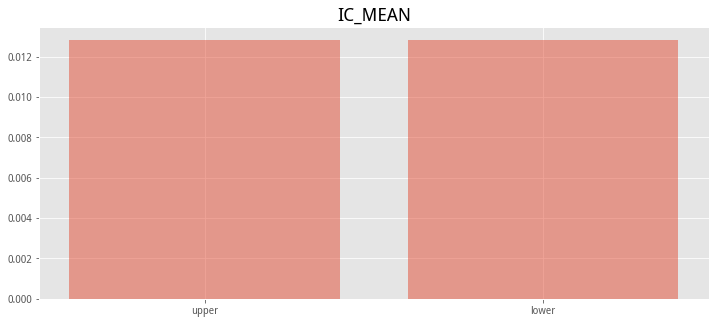

In [15]:
plt.figure(1,figsize=(12,5))
plt.bar(ic_mean.columns,ic_mean.values[0],align='center', alpha=0.5)
plt.title('IC_MEAN',fontsize=18)

In [17]:
def factor_report(far):
    '''
    far:为因子分析后的数据类型
    ---------
    return:dataframe
    '''
    # 获取最大百分位组减最小百分位组的收益率及标准差(超额收益)
    mean, std = far.compute_mean_returns_spread (by_date=False, demeaned=1)
    # 计算每组的夏普-按调仓
    longshort_sharpe=mean/std
    # 计算Mono_score(超额收益)
    ## 因子为升序排列10因子最大，1最小，研报中10组为降序
    ## MONO_Score，主要组别情况
    Numerator_mean, _ = far.compute_mean_returns_spread (upper_quant=1,lower_quant=10,by_date=False,demeaned=1)
    Denominator_mean,_=far.compute_mean_returns_spread (upper_quant=3,lower_quant=8,by_date=False, demeaned=1)
    MONO_Score=Numerator_mean/Denominator_mean
    # IC_IR
    IC_IR=far.calc_mean_information_coefficient(method='rank')
    IC=far.calc_mean_information_coefficient(method='normal')
    # 换手率
    ## 计算每组持仓的平均换手率
    v=[]
    data_dic=far.quantile_turnover
    periods=data_dic.keys()
    for period in periods:
        temp=data_dic[period].mean()
        v.append(temp.mean())
    turnover=pd.Series(v,index=periods)
    report=pd.concat([IC,IC_IR,longshort_sharpe,MONO_Score,turnover],axis=1)
    report.columns=['IC','IC_IR','LongShort_sharpe','MONO_Score','Turnover']
    return report

# 查看持仓周期报告
def trans2period(fardic,period):
    '''
    fardic:dic,key为far名称,为far数据
    period：为调仓周期
    ---------
    return:dataframe
    '''
    rList=[]
    for farname,farvalue in fardic.items():
        r_x=factor_report(farvalue).loc['period_'+str(period)]
        r_x.name=farname
        rList.append(r_x)
    datas=pd.concat(rList,axis=1)
    return datas.T

In [18]:
k=['upper','lower']
v=[far_upper,far_lower]
basic_far=dict(zip(k,v))
basic_far
trans2period(basic_far,5)

,IC,IC_IR,LongShort_sharpe,MONO_Score,Turnover
upper,0.016925,0.012826,5.411951,56.672024,0.000779
lower,0.016925,0.012826,5.411951,56.672024,0.000779


<Figure size 432x288 with 0 Axes>

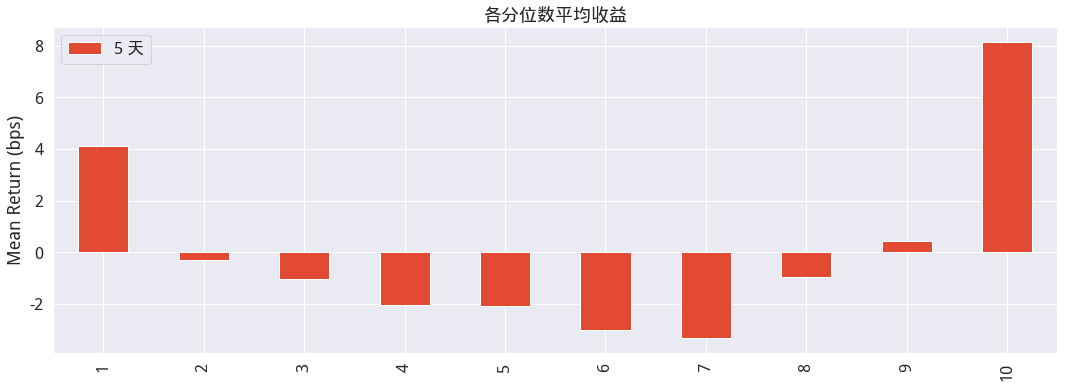

In [19]:
basic_far['upper'].plot_quantile_returns_bar(demeaned=1)

<Figure size 432x288 with 0 Axes>

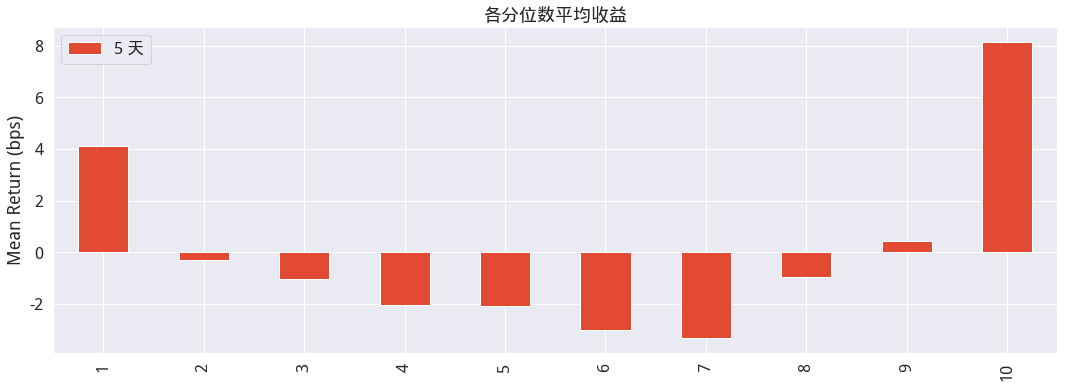

In [20]:
basic_far['lower'].plot_quantile_returns_bar(demeaned=1)

<Figure size 432x288 with 0 Axes>

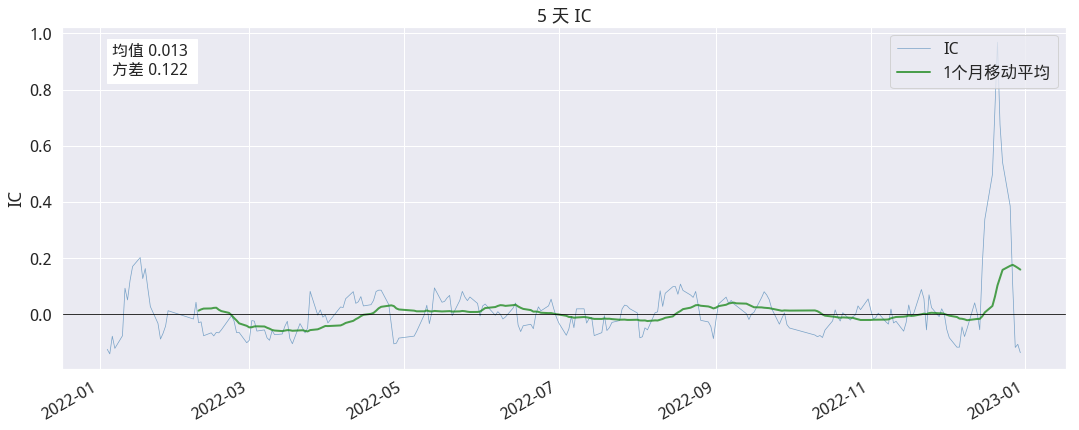

In [21]:
basic_far['upper'].plot_ic_ts(method='rank')

<Figure size 432x288 with 0 Axes>

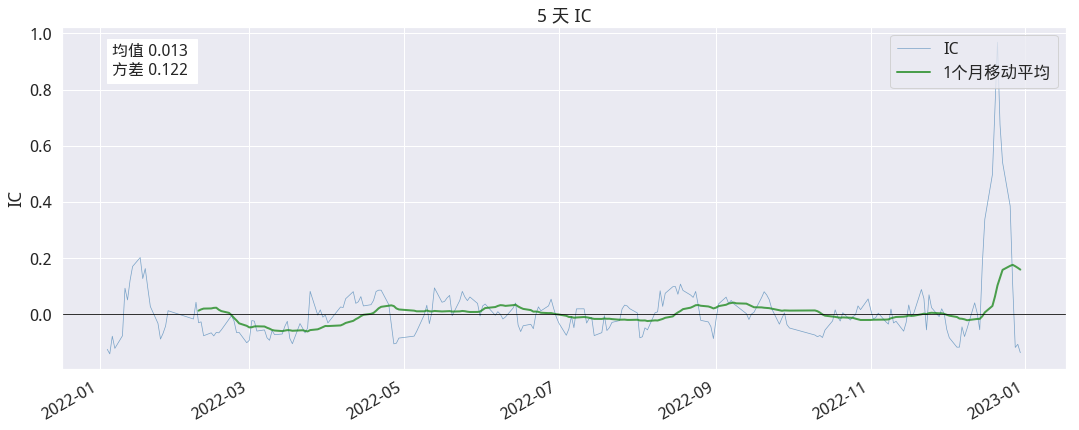

In [22]:
basic_far['lower'].plot_ic_ts(method='rank')

提纯后的多空净值为-0.0978,原始因子多空收净值为-0.0978


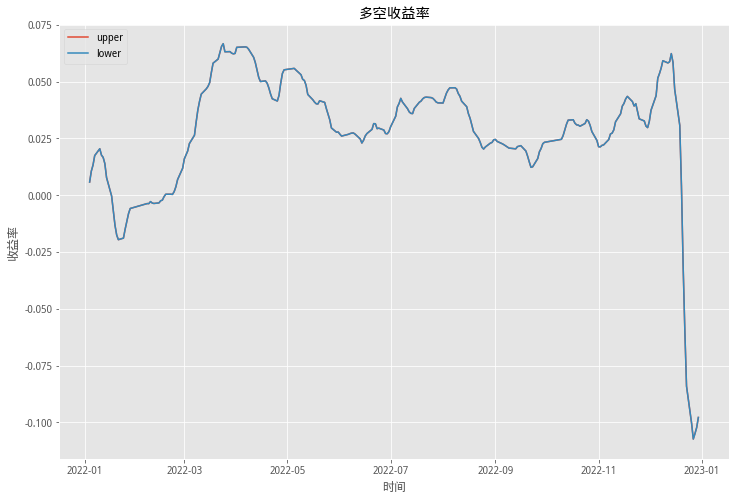

In [23]:
up_mean, _ = basic_far['upper'].compute_mean_returns_spread (upper_quant=1,lower_quant=10,by_date=True,demeaned=True)
low_mean, _ = basic_far['lower'].compute_mean_returns_spread (upper_quant=1,lower_quant=10,by_date=True,demeaned=True)


up_cum=up_mean.cumsum()
low_cum=low_mean.cumsum()

print('提纯后的多空净值为%2.4f,原始因子多空收净值为%2.4f'%(up_cum.iloc[-1][0],low_cum.iloc[-1][0]))
plt.figure(figsize=(12,8))
plt.title("多空收益率")
plt.xlabel("时间")
plt.ylabel("收益率")

plt.plot(up_cum,label="upper")
plt.plot(low_cum,label="lower")
plt.legend()

In [3]:
import zipfile
with zipfile.ZipFile('ubl.zip','r') as zip_ref:
    zip_ref.extractall()